In [1]:
import mpi4py
import pyomo.environ as pyo
import mpisppy.utils.sputils as sputils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
def build_model(t_xi, s_xi, F, c_pv, c_wind, c_storage, c_in, c_out, timesteps, time_scale, storage_scale, pv, wind, demand):
    model = pyo.ConcreteModel()

    # Variables
    # units of pv, wind and storage to buy
    model.u_pv = pyo.Var(within=pyo.NonNegativeReals)
    model.u_wind = pyo.Var(within=pyo.NonNegativeReals)
    model.u_storage = pyo.Var(within=pyo.NonNegativeReals)
    # trading energy with the grid
    model.grid_out = pyo.Var([t for t in timesteps], within=pyo.NonNegativeReals)
    model.grid_in = pyo.Var([t for t in timesteps], within=pyo.NonNegativeReals)
    # 
    model.storage = pyo.Var([t for t in timesteps], within=pyo.Reals)
    model.buyback = pyo.Var([t for t in timesteps], within=pyo.Reals)

    # Objectives
    model.INVESTMENT_COST = (model.u_pv*c_pv+model.u_wind*c_wind+model.u_storage*c_storage)/time_scale
    model.OPERATION_COST = sum(model.grid_in)*c_in - sum(model.grid_out)*c_out
    model.FLEXIBILITY_COST = sum(model.buyback)*c_in
    model.OBJ = pyo.Objective(
        expr=model.INVESTMENT_COST + model.OPERATION_COST + model.FLEXIBILITY_COST,
        sense=pyo.minimize)
    
    # Constraints
    model.CONSTR = pyo.ConstraintList()
    # Kirchhoff's 1st rule in 3 different time intervals
    for t in range(t_xi):
        model.CONSTR.add(model.buyback[t]==0)
        model.CONSTR.add(model.grid_in[t] - model.grid_out[t] + model.u_pv*pv[t] + model.u_wind*wind[t] - demand[t] + model.storage[t] == 0)
    # at t=t_xi:
    model.CONSTR.add(model.grid_in[t_xi]-model.grid_out[t_xi]+model.u_pv*pv[t_xi]+model.u_wind*wind[t_xi]-demand[t_xi]+model.storage[t_xi]+F*s_xi+model.buyback[t_xi]==0)
    for t in range(t_xi+1, len(timesteps)):
        model.CONSTR.add(model.grid_in[t]-model.grid_out[t]+model.u_pv*pv[t]+model.u_wind*wind[t]-demand[t]+model.storage[t]+model.buyback[t]==0)
    # Storage capacity
    for t in timesteps:
        model.CONSTR.add(pyo.summation(model.storage, index = range(t))>=-0.5*model.u_storage*storage_scale)
        model.CONSTR.add(pyo.summation(model.storage, index = range(t))<=0.5*model.u_storage*storage_scale)
    model.CONSTR.add(pyo.summation(model.storage) == 0) 
    return model

In [3]:
def plot_results(model, pv_data, wind_data, demand_data):
    pv = pyo.value(model.u_pv)*pv_data
    wind = pyo.value(model.u_wind)*wind_data
    g_i = [pyo.value(model.grid_in[i]) for i in range(len(demand_data))]
    g_o = [-pyo.value(model.grid_out[i]) for i in range(len(demand_data))]
    grid = [g_o[i] if g_i[i]==0 else g_i[i] for i in range(len(demand_data))]
    storage = [pyo.value(model.storage[i]) for i in range(len(demand_data))]
    buyback = [pyo.value(model.buyback[i]) for i in range(len(demand_data))]
    plt.plot(pv, label = "pv")
    plt.plot(wind, label = "wind")
    plt.plot(-demand_data, label = "demand")
    plt.plot(grid, label = "grid connection")
    plt.plot(storage, label = "storage")
    plt.plot(buyback, label = "buy-back")
    plt.show()

In [4]:
# Define model parameters
c_in = .03
c_out = .01
timesteps = range(240)
time_scale = 10. *365*24/len(timesteps)
c_pv = 1000.
c_wind = 1000.
c_storage = 400.
c_flex = .5
F = 100
storage_scale = 1.
pv_data = np.genfromtxt("../data/pv_Halle18.csv", delimiter=",")[1:(len(timesteps)+1)]
wind_data = np.genfromtxt("../data/wind_Karholz.csv", delimiter=",")[1:(len(timesteps)+1)]
demand_data = np.genfromtxt("../data/demand_Industriepark.csv", delimiter=",")[1:(len(timesteps)+1)]

1434.0
u_pv = 0.0
u_wind = 0.0
u_storage = 0.0


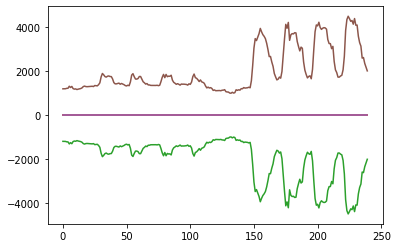

In [5]:
model = build_model(0, 0., 0., c_pv, c_wind, c_storage, c_in, c_out, timesteps, time_scale, storage_scale, pv_data, wind_data, demand_data)
solver = pyo.SolverFactory("cbc")
solver.solve(model)
print(f"{pyo.value(model.OBJ):.1f}")
print("u_pv = "+f"{pyo.value(model.u_pv)}")
print("u_wind = "+f"{pyo.value(model.u_wind)}")
print("u_storage = "+f"{pyo.value(model.u_storage)}")
plot_results(model, pv_data, wind_data, demand_data)

In [6]:
def scenario_creator(scen_name):
#def scenario_creator(N_scen, c_pv, c_wind, c_storage, c_in, c_out, timesteps, time_scale, storage_scale, pv, wind, demand):
    t_xi = random.randint(0, len(timesteps))
    s_xi = -1
    F = 100.
    model = build_model(t_xi, s_xi, F, c_pv, c_wind, c_storage, c_in, c_out, timesteps, time_scale, storage_scale, pv_data, wind_data, demand_data)
    sputils.attach_root_node(model, [model.INVESTMENT_COST, model.OPERATION_COST], [model.u_pv, model.u_pv, model.u_storage, model.grid_in, model.grid_out])
    model._mpisppy_probability = 1.0 / 3
    return model

In [7]:
from mpisppy.opt.ef import ExtensiveForm

options = {"solver": "cbc"}
#all_scenarios = [[10, 0, 0., 0., c_pv, c_wind, c_storage, c_i, c_o, timesteps, time_scale, storage_scale, pv_data, wind_data, demand_data] for i in range(10)]
all_scenarios = ["1", "2", "3"]

ef = ExtensiveForm(options, all_scenarios, scenario_creator)
results = ef.solve_extensive_form()

objval = ef.get_objective_value()
print(f"{objval:.1f}")


[   13.41] Initializing SPBase
1434.0


In [8]:
soln = ef.get_root_solution()
for (var_name, var_val) in soln.items():
    print(var_name, var_val)

u_pv 0.0
u_storage 0.0
grid_in[0] 1197.6
grid_in[1] 1201.6
grid_in[2] 1200.8
grid_in[3] 1220.0
grid_in[4] 1222.4
grid_in[5] 1315.2
grid_in[6] 1257.6
grid_in[7] 1305.6
grid_in[8] 1206.828
grid_in[9] 1183.58
grid_in[10] 1193.696
grid_in[11] 1164.728
grid_in[12] 1182.104
grid_in[13] 1194.048
grid_in[14] 1209.864
grid_in[15] 1240.0
grid_in[16] 1300.0
grid_in[17] 1321.6
grid_in[18] 1299.2
grid_in[19] 1294.4
grid_in[20] 1299.2
grid_in[21] 1301.6
grid_in[22] 1311.2
grid_in[23] 1313.6
grid_in[24] 1300.8
grid_in[25] 1347.2
grid_in[26] 1340.0
grid_in[27] 1332.0
grid_in[28] 1386.4
grid_in[29] 1469.6
grid_in[30] 1740.0
grid_in[31] 1896.8
grid_in[32] 1836.0
grid_in[33] 1757.2
grid_in[34] 1730.524
grid_in[35] 1771.0
grid_in[36] 1783.572
grid_in[37] 1757.6
grid_in[38] 1755.832
grid_in[39] 1647.2
grid_in[40] 1479.2
grid_in[41] 1424.8
grid_in[42] 1424.0
grid_in[43] 1441.6
grid_in[44] 1457.6
grid_in[45] 1406.4
grid_in[46] 1441.6
grid_in[47] 1416.0
grid_in[48] 1385.6
grid_in[49] 1344.0
grid_in[50] 1328.8